# The Evidence Approximation

Hyperparameter selection for a bayesian linear model

In [273]:
import numpy as np
import matplotlib.pyplot as plt
from branca.colormap import LinearColormap
from numpy.random import randn, seed
from numpy.linalg import inv, norm, det, eigvals

In [5]:
%config InlineBackend.figure_format = "retina"

### Creating the Sinusoidal Synthetic Data

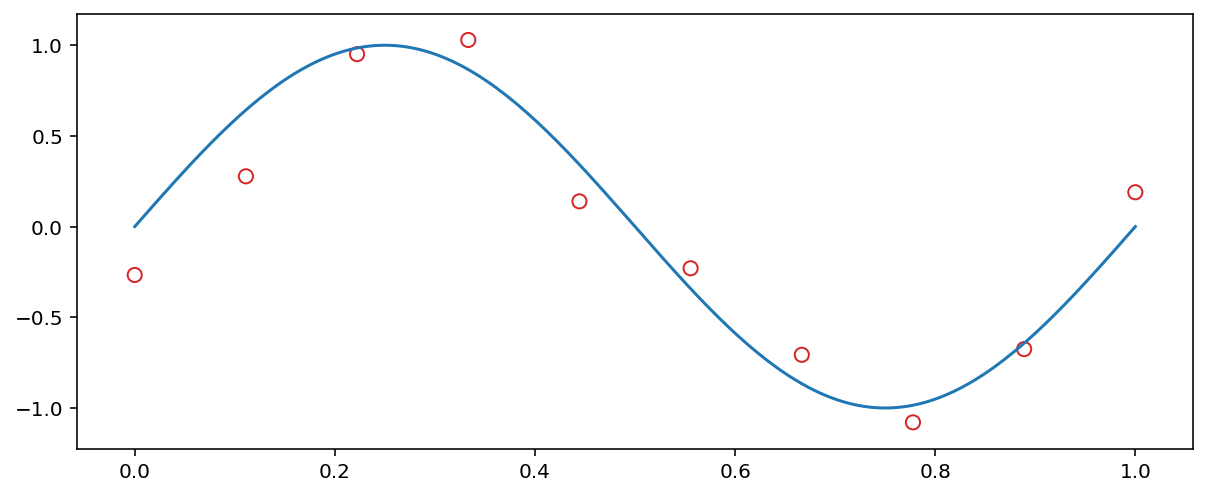

In [6]:
seed(1643)

nsteps = 200
x = np.linspace(0, 1, 200)
t_true = np.sin(2 * np.pi * x)

precision = 1 / 0.15
N = 10
x_train = np.linspace(0, 1, N)
t_train = np.sin(2 * np.pi * x_train) + randn(N) / precision

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(x, t_true)
ax.scatter(x_train, t_train, edgecolors="tab:red", c="None", s=50);

## The Setting

Consider a probabilistic model with basis function $\phi$ and a training dataset $({\bf t}, {\bf x}) = \{(t_n, {\bf x}_n)\}_{n=1}^N$. The predictive distribution, considering a model of the form $t \sim \mathcal{N}\left(y({\bf x}, {\bf w}), \beta^{-1}\right)$ is given by

$$
    p(t | {\bf t}, {\bf x}, M_i) = \int\int\int p(t, \alpha, \beta, {\bf w} | {\bf t}, {\bf x}, M_i) \ d{\bf w} \ d\alpha  \ d\beta
$$

With priors
$$
    p({\bf w} | \beta) = \mathcal{N}({\bf w} | {\bf 0}, \alpha^{-1}\bf{I})
$$
$$
    p(t | {\bf w}, \beta) = \mathcal{N}(t | \Phi {\bf w}, \beta^{-1})
$$

Then,

$$
\begin{align}
    p(t | {\bf t}) &= \int\int\int p(\alpha, \beta | {\bf t}) p({\bf w} | \alpha, \beta, {\bf t}) p(t|\alpha, \beta, {\bf w}) \ d{\bf w} \ d\alpha  \ d\beta\\
    &= \int\int\int p(t|\beta, {\bf w}) p({\bf w} | \alpha, {\bf t}) p(\alpha, \beta | {\bf t}) \ d{\bf w} \ d\alpha  \ d\beta \\
\end{align}
$$

Since this last integral is analytically intractable, consider

$$
    p(\alpha, \beta | {\bf t}) \propto p(\alpha, \beta) p({\bf t} | \alpha, \beta)
$$

Assuming a noninformative prior, i.e., $\alpha$ and $\beta$ are uniformly distributed and that there exists $\hat \alpha$, $\hat \beta$ that maximizes the posterior, to maximize $p(\alpha, \beta | {\bf t})$ suffices to maximize the *evidence* $p({\bf t} | \alpha, \beta)$

For a given model $M_i$, the log-evidence function is given by
$$
    \log p({\bf t} | \alpha, \beta) = -\frac{N}{2} \log 2\pi + \frac{N}{2}\log\beta + \frac{M}{2}\log\alpha - \frac{1}{2}\log |{\bf S}_N^{-1}| - E({\bf m}_N)
$$

Where
* ${\bf S}_N^{-1} = \alpha {\bf I} + \beta \Phi^T\Phi$
* ${\bf m}_N = \beta S_N \Phi^T {\bf t}$
* $E(m_N) = \frac{\beta}{2}{||{\bf t} - \Phi m_N||}^2 + \frac{\alpha}{2}m_N^Tm_N$

Hence, our predictive distribution takes the form

$$
    p(t | {\bf t}) = \int p(t|\hat \beta, {\bf w}) p({\bf w}|\hat \alpha, {\bf t}) d{\bf w}
$$

where $\hat \alpha$, $\hat \beta$ was found maximizing the *log-evidence*

## Evaluating the Evidence Function

In [7]:
def gaussian_kernel(x, mu, s): return np.exp(-(x - mu)**2 / (2 * s ** 2))

def gaussian_design_matrix(x, mus, s, bias=True):
    """
    Create an N x (M + 1) desig matrix (if bias == True)
    with Gaussian basis functions
    
    Parameters
    ----------
    mus: numpy.ndarray(M, 1)
        Centres of the gaussian basis functions
    x: numpy.ndarra(N, 1)
        A 1-dimensional input vector
    s: float
        The scale term
    bias: bool
        Whether to include a bias term
    
    Returns
    -------
    Phi: numpy.ndarray(N, (M + bias))
    """
    Phi = gaussian_kernel(x[:, np.newaxis], mus[np.newaxis, :], s)
    if bias:
        r, _ = Phi.shape
        onevect = np.ones(r)
        Phi = np.column_stack((onevect, Phi))
    return Phi

def polynomial_design_matrix(x, powers, bias=True):
    """
    Create an N x (M + 1) desig matrix (if bias == True)
    with Gaussian basis functions
    
    Parameters
    ----------
    mus: numpy.ndarray(M, 1)
        Centres of the gaussian basis functions
    x: numpy.ndarra(N, 1)
        A 1-dimensional input vector
    s: float
        The scale term
    bias: bool
        Whether to include a bias term
    
    Returns
    -------
    Phi: numpy.ndarray(N, (M + bias))
    """
    Phi = np.column_stack((x ** p for p in powers))
    if bias:
        r, _ = Phi.shape
        onevect = np.ones(r)
        Phi = np.column_stack((onevect, Phi))
    return Phi


def posterior(Phi, t, alpha, beta):
    """
    Compute the posterior mean and covariance matrix
    for a set of weights with prior an isotropic gaussian.
    
    Parameters
    ----------
    Phi: numpy.ndarray (N, M)
        An N x M design matrix
    t: numpy.ndarray (N,)
        The training dataset
    alpha: float
        The prior 
    beta: float 
    
    Returns
    -------
    mN: numpy.ndarray(M, 1)
    SN: numpy.ndarray(M, M)
    """
    SN_inv = alpha + beta * Phi.T @ Phi
    mN = beta * inv(SN_inv) @ Phi.T @ t[:, np.newaxis]
    return mN, SN_inv


def log_evidence(M, alpha, beta, s=0.5):
    """
    Compute the log-evidence for a design matrix
    with gaussian basis functions
    """
    mus = np.linspace(0, 1, M)
    Phi = gaussian_design_matrix(x_train, mus, s, bias=True)
    mN, SN_inv = posterior(Phi, t_train, alpha, beta)
    
    E_mN = beta / 2 * norm(t_train[:, np.newaxis] - Phi @ mN) ** 2 + alpha / 2 * mN.T @ mN
    log_ev = N / 2 * np.log(beta) + M / 2 * np.log(alpha) - \
             1 / 2 * np.log(det(SN_inv)) - E_mN - N / 2  * np.log(2 * np.pi)
    return np.asscalar(log_ev)

### Computing the log-evidence for a linear regression model with $M$ Gaussian basis functions

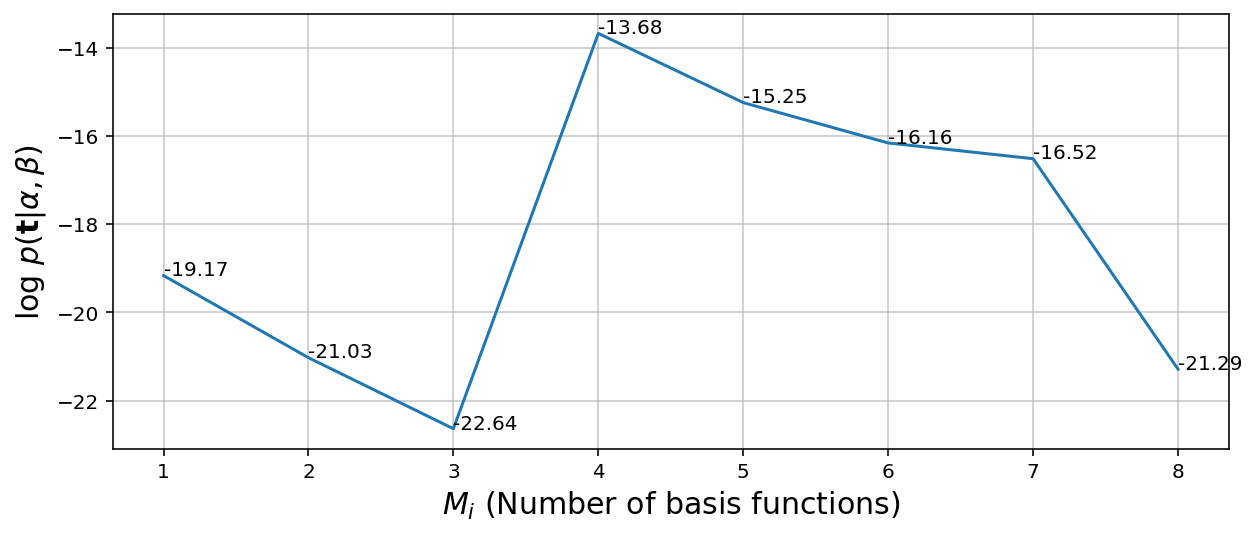

In [8]:
alpha, beta = 0.01, precision + 1
s = 0.2
models = [1, 2, 3, 4, 5, 6, 7, 8]

evidences = [log_evidence(M, alpha, beta, s=s) for M in models]

plt.figure(figsize=(10, 4))
plt.plot(models, evidences)
for m, ev in zip(models, evidences):
    plt.text(m, ev, f"{ev:0.2f}", horizontalalignment="left")
plt.grid(alpha=0.7)
plt.xlabel("$M_i$ (Number of basis functions)", size=15)
plt.ylabel(r"$\log\ p({\bf t} | \alpha, \beta)$", size=15);

### Plotting the various model hypothesis for a given $\alpha$

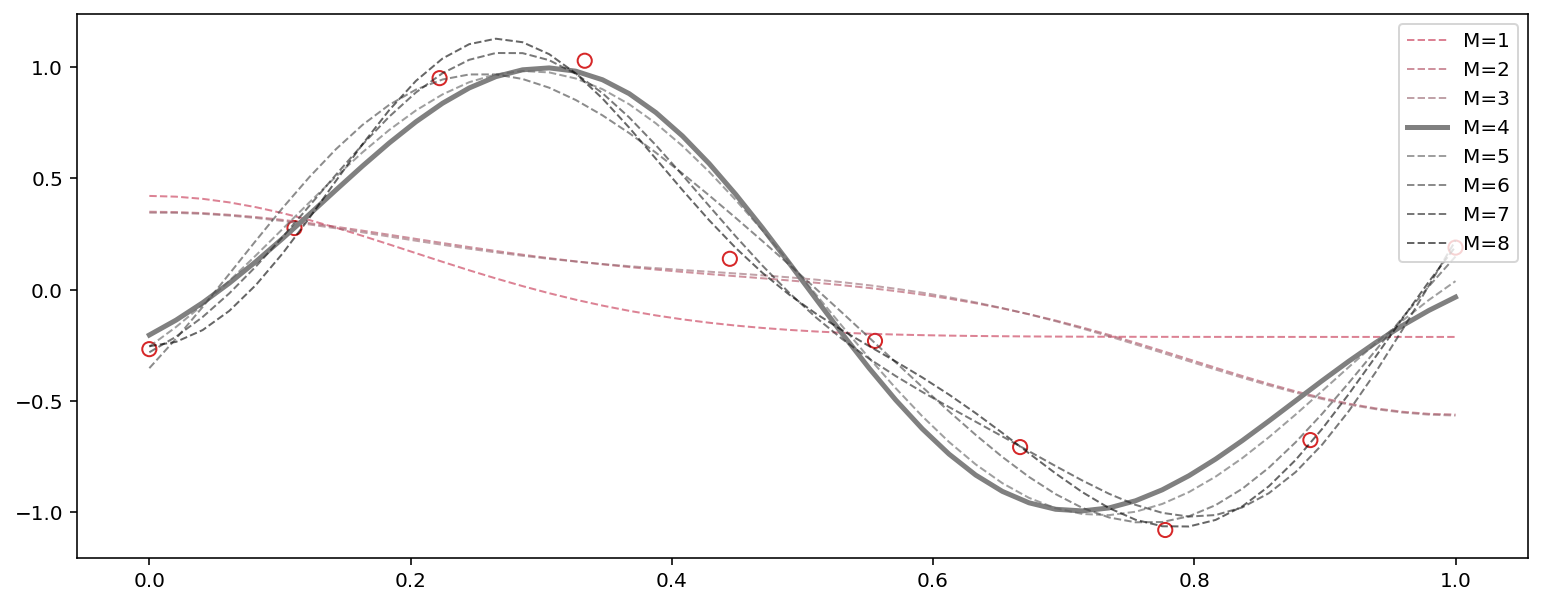

In [9]:
plt.figure(figsize=(13, 5))
plt.scatter(x_train, t_train, c="None", s=50, edgecolor="tab:red")
cmap = LinearColormap(["crimson", "gray", "black"])
for i, M in enumerate(models):
    mus = np.linspace(0, 1, M)
    Phi = gaussian_design_matrix(x_train, mus, s)
    mN, SN_inv = posterior(Phi, t_train, alpha, beta)
    x_in = np.linspace(0, 1, 50)
    phi_x = gaussian_design_matrix(x_in, mus, s, bias=True)
    linestyle = "--" if M != 4 else "-"
    alpha = 0.6 if M != 4 else 1
    linewidth = 1 if M != 4 else 2.5
    plt.plot(x_in, (mN.T @ phi_x.T).ravel(), label=f"M={M}",
             linestyle=linestyle, alpha=alpha,
             linewidth=linewidth,
             c=cmap((i + 1) / len(models)))
plt.legend();

## Maximizing the Evidence Function
With the log-evidence function, for a given model $M_i$, it can be show that $\alpha$ and $\beta$ that maximize the evidence function are given by

$$
    \alpha = \frac{\gamma}{{\bf m}_N^T {\bf m}_N} \qquad \frac{1}{\beta} = \frac{1}{N - \gamma}\sum_{n=1}^N \left(t_n - {\bf m}_N^T \phi({\bf x}_n) \right)^2
$$

With
$$
    \gamma = \sum_i \frac{\lambda_i}{\alpha + \lambda_i}
$$

Where

* $\{\lambda_i\}_i$ are the eigenvalues of the matrix $\beta\Phi^T\Phi$

The following procedure re-estimates $\hat\alpha$ and $\hat\beta$ until a certain tolerance is reached. It seems that values of $\alpha$ fluctuate around certain value, whereas values for $\beta$ oscilate in a disproportionate way.

In [334]:
alpha, beta = 0.01, -.5

## Model selection ##
M = 10 # gaussian basis functions + bias term
mus = np.linspace(0, 1, M)
Phi = gaussian_design_matrix(x_train, mus, s)
N = Phi.shape[0]

delta_alpha, delta_beta = np.inf, np.inf
tol = 2e-5
alpha_hist, beta_hist = [], []
phi_eigs = eigvals(Phi.T @ Phi)
mN, SN_inv = posterior(Phi, t_train, alpha, beta)
while delta_alpha > tol and delta_beta > tol:
    # Update eigenvalues of the matrix
    lambdas = phi_eigs * beta
    gamma = (lambdas / (lambdas + alpha)).sum()
    # Update model parameters
    mN, SN_inv = posterior(Phi, t_train, alpha, beta)
    # Compute new hyperparams
    new_alpha = gamma / np.asscalar(mN.T @ mN)
    new_beta = (Phi.shape[0] - gamma) / ((t_train[:, np.newaxis] - Phi @ mN) ** 2).sum() 
    # Compute the percentual change in hyperparams
    delta_alpha = np.abs(new_alpha / alpha - 1)
    delta_beta = np.abs(new_beta / beta - 1)
    # Update alpha, beta
    alpha, beta = new_alpha, new_beta
    alpha_hist.append(alpha)
    beta_hist.append(beta)

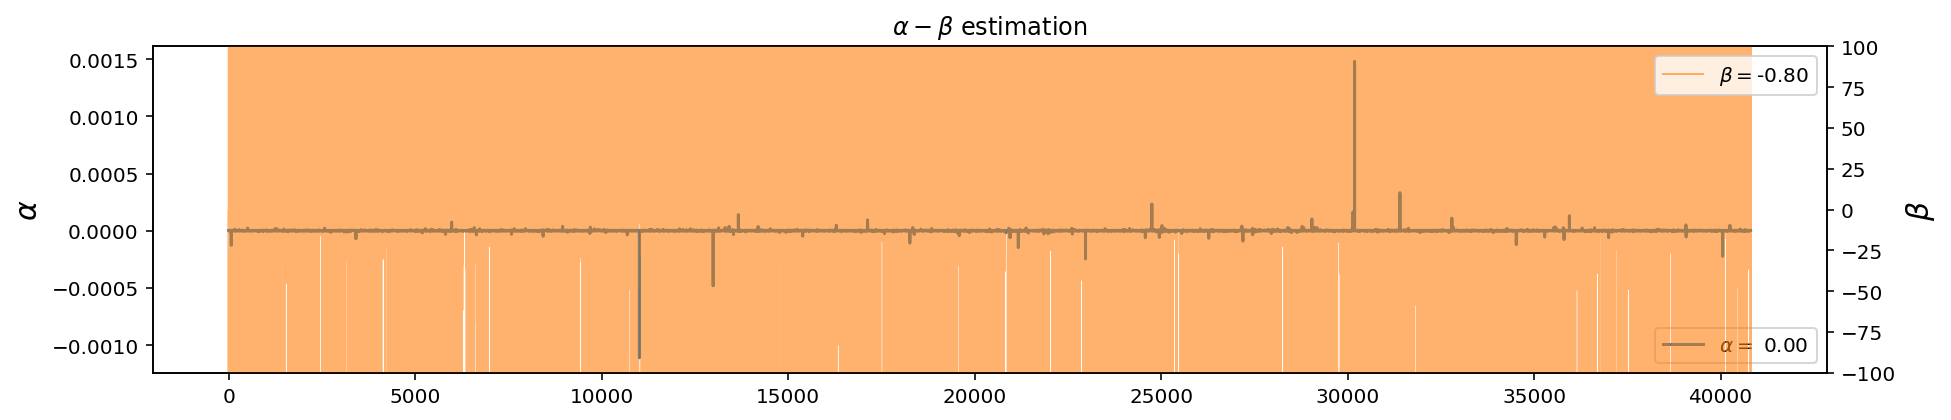

In [335]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(alpha_hist, label=r"$\alpha=$" f" {alpha:0.2f}")
ax2 = ax.twinx()
ax2.plot(beta_hist, c="tab:orange", label=r"$\beta=$" f"{beta:0.2f}", linewidth=1, alpha=0.6)
ax.legend(loc="lower right")
ax.set_ylabel(r"$\alpha$", fontsize=15)
ax2.legend(loc="upper right")
ax2.set_ylabel(r"$\beta$", fontsize=15)
ax2.set_ylim(-100, 100)
plt.title(r"$\alpha-\beta$ estimation");

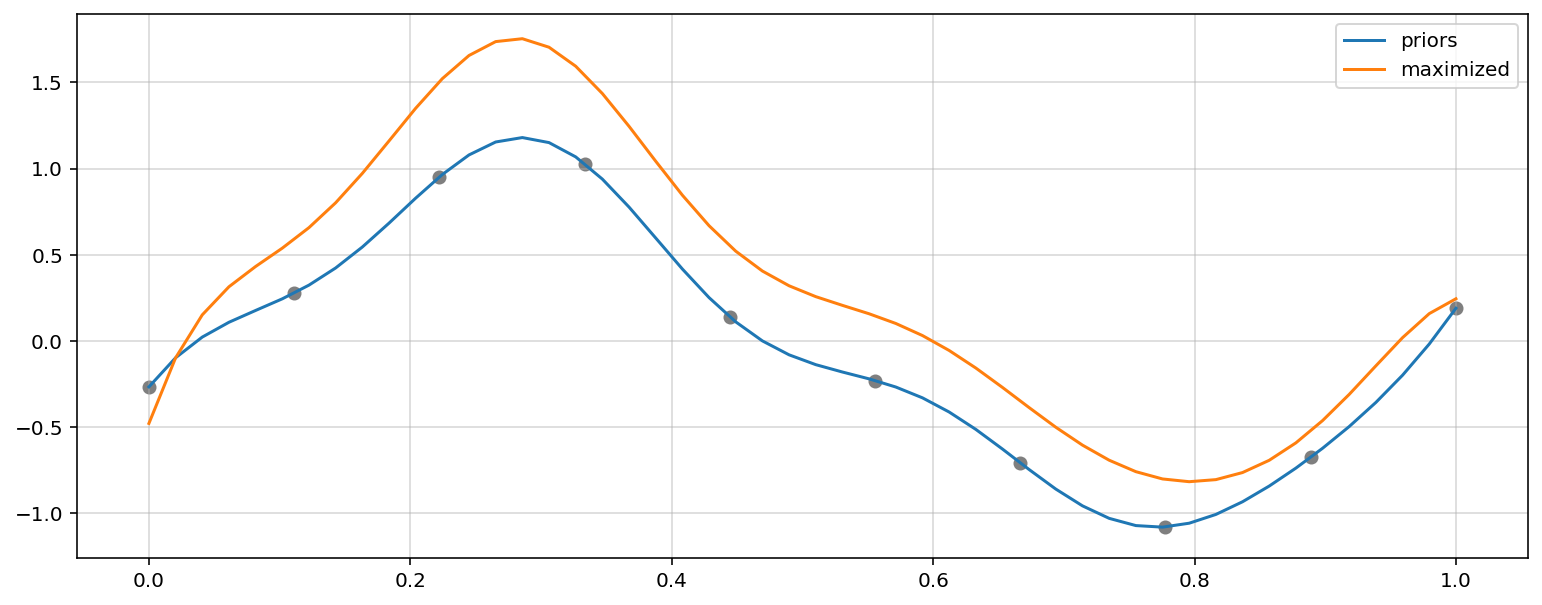

In [336]:
plt.figure(figsize=(13, 5))
alpha_prior, beta_prior = 0.001, 100
phi_x = gaussian_design_matrix(x_in, mus, s, bias=True)
mN_prior, SN_inv_prior = posterior(Phi, t_train, alpha_prior, beta_prior)

plt.plot(x_in, (mN_prior.T @ phi_x.T).ravel(), label="priors")
plt.plot(x_in, (mN.T @ phi_x.T).ravel(), label="maximized")
plt.scatter(x_train, t_train, c="tab:gray")
plt.grid(alpha=0.5)
plt.legend();

## Remarks

* It seems that my implmentation of the maximization of the evidence function overfits the training dataset; as opposed to penalize the model for complexity

## Cross-Validation for the hyperparameters

There exists an apparent instability of the system of equations required to solve for $\hat\alpha$ and $\hat\beta$.

In [346]:
M = 10
mus = np.linspace(0, 1, M)
Phi = gaussian_design_matrix(x_train, mus, s)

Ncv = 5
x_cv = np.linspace(0, 1, Ncv)
t_cv = np.sin(2 * np.pi * x_cv) + randn(Ncv) / precision
Phi_cv = gaussian_design_matrix(x_cv, mus, s)

In [347]:
top, bottom, step = 1, 0.1, 0.01
nvals = int((top - bottom) / step)

ab_mat = np.mgrid[bottom:top:step, bottom:top:step]
#ab_mat.reshape(2, -1).T.reshape(200, 200, 2).T[::-1]
coefs = ab_mat.reshape(2, -1).T
errs = []
for ai, bi in coefs:
    mN, SN = posterior(Phi, t_train, ai, bi)
    err = norm(Phi_cv @ mN - t_cv[:, np.newaxis]) ** 2
    errs.append(err)

errs = np.array(errs).reshape(nvals, nvals, 1).T[::-1][0]

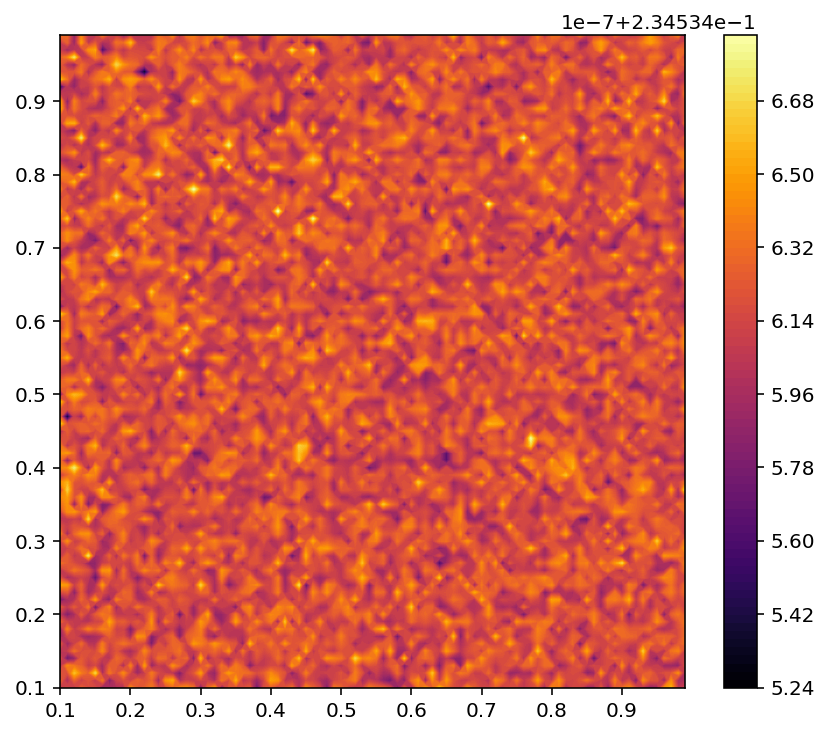

In [348]:
plt.figure(figsize=(7, 6))
plt.contourf(*ab_mat, errs, cmap="inferno", levels=100)
plt.colorbar();

Text(0.5, 1.0, 'Loss for fixed $\\alpha$ and varying $\\beta$')

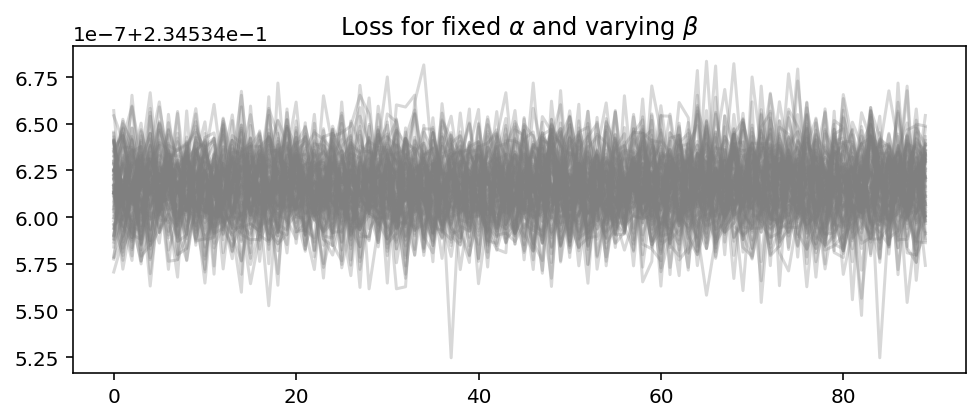

In [349]:
plt.figure(figsize=(8, 3))
for err in errs:
    plt.plot(err, c="tab:gray", alpha=0.3)
plt.title(r"Loss for fixed $\alpha$ and varying $\beta$")